In [1]:
using HVAC, ModelingToolkit, SciMLBase, OrdinaryDiffEq, ModelingToolkitStandardLibrary, ModelingToolkitStandardLibrary.Blocks
import HVAC: moistair, relativeHumidity_PTX, saturationPressure

In [2]:
# 1. Load the refrigerant: 
ref_name = "R32"
refrigerant = load_refrigerant(ref_name*".yaml")

Ref spline model

In [3]:
# 2. Choose initial conditions 

# 2.a. Refrigerant side  
## Boundary conditions 
p_in = 1.2e6
h_in = 230e3
ref_mdot_start = 0.1

## Initial guesses 
p_out = 1.1e6
h_out = 430e3

# 2.b. Air side 
## Boundary conditions
air_mdot_in = 0.2
air_p_in_start = 101325.0 
ϕ_in = 0.8
air_T_in_start = from_degC(35)

## Initial guesses 
air_p_out_start = 101325.0 - 100.0   
ϕ_out = 0.6
air_T_out_start = from_degC(15)                                                                     # To keep in line with https://help.juliahub.com/hvac/stable/vapor_compression_cycle/

# 2.c. Geometery
## Design/modle parameters 
nTube = 1
nSeg = 4
Lt = 100
Di = 2.54e-2
Do = Di + 0.5e-3

0.0259

In [5]:
# 4. Subsystems
# subsystem: Heat exchanger
HX_record = MERLTubeFinHEXRecord(; nTube, nSeg, Lt, Di, Do, ## Design parameters (DO affect results)

    ## Initial guesses (NOT affect results)
    ### Normally, we use input signals at t=0 for inlet inital guesses. In this case, by chance, the input signals are constant.
    ref_model_structure = av_vb,    # for defination, referring to @enum ModelStructure av_vb = 1 a_v_b = 2 a_vb = 3 av_b = 4 # in utils.jl
    ref_p_in_start = p_in,     
    ref_p_out_start = p_out,
    ref_h_in_start = h_in,
    ref_h_out_start = h_out,
    ref_m_flow_start = ref_mdot_start,

    wall_T_in_start = from_degC(24),
    wall_T_out_start = from_degC(24),

    air_p_in_start,
    air_p_out_start,
    air_m_air_flow_start = air_mdot_in,
    air_T_in_start = air_T_in_start,
    air_T_out_start = air_T_out_start,
    air_Xi_in_start = moistair.Xi_ref,
    air_Xi_out_start = moistair.Xi_ref,
    air_Q_start = -50 
    )

@named heatExchanger = TubeFinHEX(HX_record)

# subsystem: refSource & Sink
## INLET boundary conditons (DO affect results)
@named refSource = MassFlowSource_h(m_flow_in = ref_mdot_start, h_in = h_in, P_start = p_in)
# subsystem: refSink
## Outlet initial guesses (NOT affect results)
@named refSink = Boundary_Ph(P_in = p_out, h_in = h_out, m_flow_start = ref_mdot_start)

# subsystem: AirSource & Sink
## INLET boundary conditons (DO affect results)
@named AirSource = MassFlowSource_Tϕ(; T_in = air_T_in_start, ϕ_in = ϕ_in, m_flow_in = air_mdot_in, P_start = air_p_in_start)
## Outlet initial guesses (NOT affect results)
@named AirSink = Boundary_PTϕ(; P_in = air_p_out_start, T_in = air_T_out_start, ϕ_in = ϕ_out, m_flow_start = air_mdot_in)

Model AirSink with 15 (16) equations
Unknowns (16):
  port1₊P(t)
  port1₊m_flow(t)
  port1₊h_outflow(t)
  port1₊Xi_outflow(t)
  medium₊P(t)
  medium₊T(t)
⋮
Parameters (3):
  P_in [defaults to 101225.0]: Moist air Source/Sink - Fixed pressure
  T_in [defaults to 288.15]: Moist air Source/Sink - Fixed temperature
  ϕ_in [defaults to 0.6]: Moist air Source/Sink - Fixed moisture fraction

In [14]:
# 5. ODESystem and prob
# Equations
## Connect each subsystem (5)
eqns = [
    # Ref
    connect(refSource.port, heatExchanger.refPort_a)
    connect(heatExchanger.refPort_b, refSink.port1)
    # Air
    connect(AirSource.port, heatExchanger.airPort_a)
    connect(heatExchanger.airPort_b, AirSink.port1)
]

systems = [heatExchanger, refSource, refSink, AirSource, AirSink]

# Define the ODE system: 
@named sys = ODESystem(eqns, t; systems)

old_eq = 0 ~ heatExchanger.air_merger.port_b.m_flow - heatExchanger.airPort_b.m_flow
new_eq = 0 ~ heatExchanger.air_merger.port_b.m_flow - heatExchanger.airPort_b.m_flow -1e-2

# Simplificaiton
sysRed = structural_simplify(sys; substitute_eqs = true, old_eq, new_eq)
sysRed_debug = debug_sysRed(sysRed)

# 调试检查，检查方程的左侧是否是一个连接方程（Connection），并打印出方程右侧（eq.rhs）系统中涉及到的两个系统的名称

connect_prints(eq) = begin
    if eq.lhs isa Connection
        println(eq.rhs.systems[1].name, " , ", eq.rhs.systems[2].name)
    end
end

connect_prints.(eqns)

# Define the ODE problem and then DAE problem


refSource₊port , heatExchanger₊refPort_a
heatExchanger₊refPort_b , refSink₊port1
AirSource₊port , heatExchanger₊airPort_a
heatExchanger₊airPort_b , AirSink₊port1


4-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing

In [15]:
tspan = (0.0, 2000.0)

prob = ODEProblem(sysRed, sysRed_debug.defs_set, tspan; guesses = ModelingToolkit.get_guesses(sysRed))
prob = init_DAE(prob, loops = 2, verbose = true, sparsity = false)

sol = solve(prob, Rodas5()) # , Rodas4(autodiff = false)

norm(out) / norm(nlu) = 3.420802838281765e-16
norm(out) / norm(nlu) = 3.420802838281765e-16


retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 104-element Vector{Float64}:
    0.0
    1.0e-6
    1.1e-5
    0.00011099999999999999
    0.0011109999999999998
    0.011110999999999996
    0.05012442694630066
    0.11155669216243261
    0.18822060345229003
    0.29145901558848525
    0.42318899819026456
    0.5940541825444432
    0.8063952633739936
    ⋮
 1097.635769769953
 1104.0394082940256
 1112.9781883013768
 1126.0601866613983
 1145.3415885553352
 1173.4864059768174
 1217.9165832578633
 1297.8743457868368
 1443.1131991246793
 1656.0803057357923
 1962.6018965979445
 2000.0
u: 104-element Vector{Vector{Float64}}:
 [1.2e6, 230000.0, 1.1666666666666667e6, 296666.6666666667, 1.1333333333333333e6, 363333.3333333333, 430000.0, 297.15, 297.15, 297.15  …  106537.27690999012, 0.02817717370374598, 308.15, 308.15, 1025.8893643970262, 0.021608469342627362, 106537.27690999012, 308.15000000000055, 101075.49833887043, 0.006315155696935889]
 [1.2000000

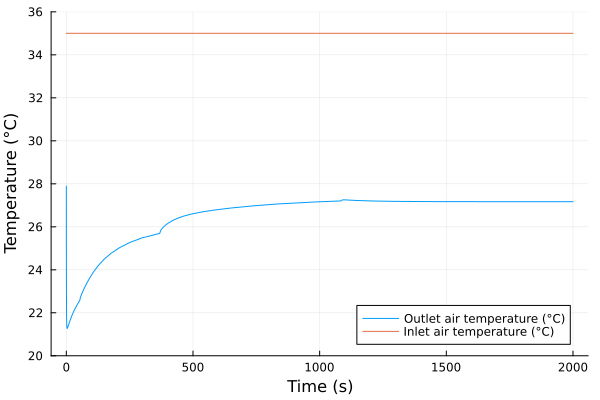

In [22]:
using Plots

t_vals = sol.t
T_out_vals_Celsius = sol[heatExchanger.Tair_out] .- 273.15

# inlet air 35°C
T_inlet_Celsius = fill(35.0, length(t_vals))

plot(t_vals, T_out_vals_Celsius, label="Outlet air temperature (°C)", xlabel="Time (s)", ylabel="Temperature (°C)", ylims=(20, 36), yticks=20:2:36)
plot!(t_vals, T_inlet_Celsius, label="Inlet air temperature (°C)")

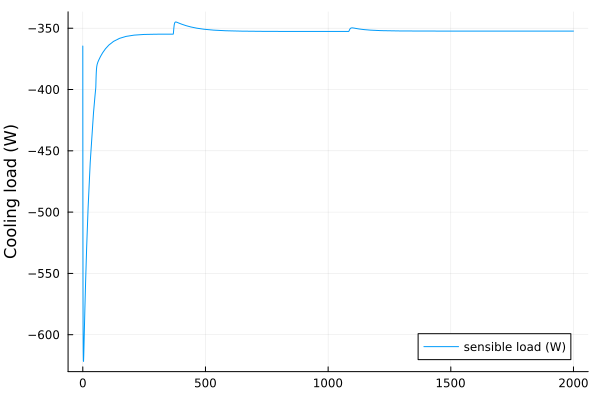

In [24]:
Sensible_out_vals = sol[heatExchanger.Qsen_tot]

plot(t_vals, Sensible_out_vals, ylabel="Cooling load (W)", label="sensible load (W)")

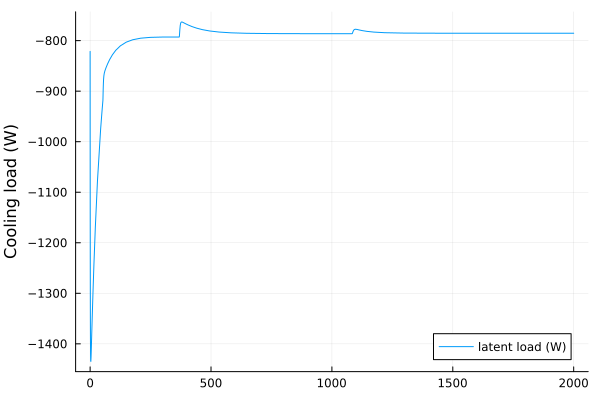

In [25]:
Latent_out_vals = sol[heatExchanger.Qlat_tot]

plot(t_vals, Latent_out_vals, ylabel="Cooling load (W)", label="latent load (W)")